In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = 'data/tawkify/'

In [5]:
sz=220

### Load Data

In [ ]:
df = pd.read_csv(PATH+'labels.csv')

In [ ]:
df.columns

In [ ]:
df['id'].size

In [ ]:
df.head()

In [ ]:
plt.imshow(plt.imread(f'{PATH}train/933e245251bc667ce6ff74f12dc998fe.jpg'))

### Download images

In [8]:
import urllib
image_folder = f'{PATH}train/'

for index, row in df.iterrows():
    user_id = row['userId']
    image_url = row['imageUrl']
    image_path = f'{image_folder}{user_id}.jpg'
    if not os.path.exists(image_path):
        urllib.request.urlretrieve(image_url, image_path)
    
# urllib.request.urlretrieve('https://www.blog.google/static/blog/images/google-200x200.7714256da16f.png', f'{PATH}00000001.jpg')

('data/tawkify/00000001.jpg', <http.client.HTTPMessage at 0x7fa984ab82e8>)

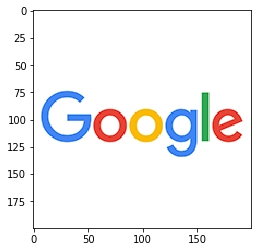

In [10]:
plt.imshow(plt.imread(f'{PATH}00000001.jpg'))

### Read images

In [ ]:
test_file = PATH+'train/'+df['id'][0]+'.jpg'
print(test_file)
test_img = plt.imread(test_file)
plt.imshow(test_img)
# PIL.Image.open(test_file)

In [ ]:
size_map = { k:plt.imread(f'{PATH}train/{k}.jpg').shape for k in df['id'][1:]}

In [ ]:
size_map

In [ ]:
h, w, ch = list(zip(*size_map.values()))

In [ ]:
plt.hist(w)

In [ ]:
w = np.array(w)
plt.hist(w[w<600])

### Architecture

In [ ]:
!rm -rf {PATH}tmp

In [ ]:
arch=resnet34

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
n = df['id'].size-1
val_idxs = get_cv_idxs(n)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=f'{PATH}labels.csv', test_name='test', tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
new_data = data.resize(sz, 'tmp')

In [ ]:
data.trn_ds[0][0].shape

In [ ]:
learn = ConvLearner.pretrained(arch, data=new_data, precompute=True)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(lrs=1e-1, n_cycle=2)

In [ ]:
learn.fit(lrs=1e-2, n_cycle=2)

In [ ]:
learn.precompute=False

In [ ]:
learn.fit(lrs=1e-2, n_cycle=3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_len=1)

In [ ]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_mult=2)

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)

In [ ]:
preds = np.argmax(log_preds, axis=1)
# np.array(preds==y).mean()
preds
# accuracy(log_preds,y)